```
Copyright 2017 Kyungtaek Jun
Licensed under the MIT License
https://www.mit.edu/~amini/LICENSE.md

Python notebook written by Byung Chun Kim
```

# Virtual Alignment Method for Rigid Sample with Phantom Image

* Scientific Reports, 2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, radon, iradon
import cv2

## Padded Phantom Image

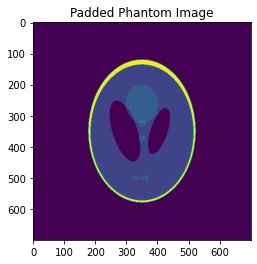

In [2]:
pad = 100

phantom = shepp_logan_phantom()  # (400, 400)
phantom = rescale(phantom, 1.25) # (500, 500)
phantom = np.pad(phantom, ((pad,pad),(pad,pad))) # (700, 700)

plt.figure()           
plt.title('Padded Phantom Image')
plt.imshow(phantom, vmin=0, vmax=1)
plt.show()

## Radon and Inverse Radon Transform

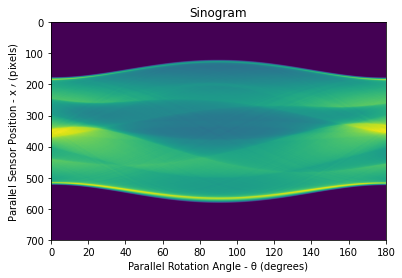

In [3]:
theta = np.arange(0, 180, 0.5)

sino = radon(phantom, theta)
plt.figure()
plt.title('Sinogram')
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.imshow(sino, aspect='auto', extent=[0,180,700,0])
plt.show()

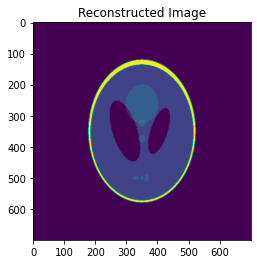

In [4]:
recon = iradon(sino, np.arange(0,180,0.5))
plt.figure()
plt.title('Reconstructed Image')
plt.imshow(recon, vmin=0, vmax=1)
plt.show()

## Vertical and Parallel Translation Errors

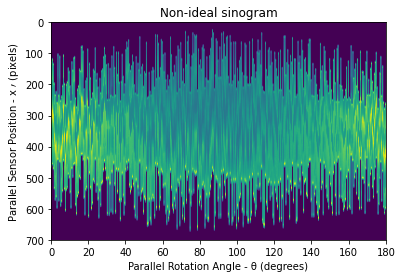

In [5]:
np.random.seed(1234)
err = np.random.randint(-pad,pad+1,360)

sino_nonideal = np.empty_like(sino)

for j in range(sino.shape[1]):
    idx = np.roll(np.arange(sino.shape[0]), err[j])
    sino_nonideal[:,j] = sino[idx,j]

plt.figure()
plt.title('Non-ideal sinogram')
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.imshow(sino_nonideal, aspect='auto', extent=[0,180,700,0])
plt.show()

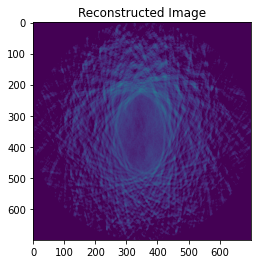

In [6]:
recon_nonideal = iradon(sino_nonideal, theta)
plt.figure()
plt.title('Reconstructed Image')
plt.imshow(recon_nonideal, vmin=0, vmax=1)
plt.show()

## Virtual Alignment Method

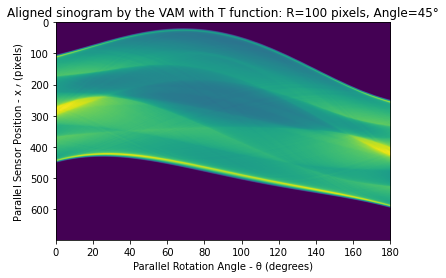

In [7]:
fp_r = 100
fp_phi = 45

T = fp_r * np.cos(np.deg2rad(theta-fp_phi))

pjtd_CA_x = np.arange(sino_nonideal.shape[0]).reshape(-1,1)*sino_nonideal
pjtd_CA_x = pjtd_CA_x.sum(axis=0)
pjtd_CA_x /= sino_nonideal.sum(axis=0)  # total MAC
pjtd_CA_x += T

# interpolate
ratio_r = pjtd_CA_x - np.floor(pjtd_CA_x)
ratio_l = np.ceil(pjtd_CA_x) - pjtd_CA_x
ratio_l[ratio_l==0] = 1
sino_ideal = sino_nonideal[:-1,:]*ratio_l + sino_nonideal[1:,:]*ratio_r

move = np.round(sino_nonideal.shape[0]/2) - np.floor(pjtd_CA_x)
for j in range(len(theta)):
    sino_ideal[:,j] = np.roll(sino_ideal[:,j], int(move[j]))

plt.figure()
plt.title(f'Aligned sinogram by the VAM with T function: R={fp_r} pixels, Angle={fp_phi}\u00B0')
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.imshow(sino_ideal, aspect='auto', extent=[0,180,699,0])
plt.show()

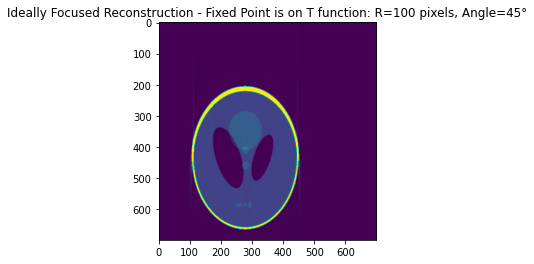

In [8]:
recon_ideal = iradon(sino_ideal, theta)
plt.figure()
plt.title(f'Ideally Focused Reconstruction - Fixed Point is on T function: R={fp_r} pixels, Angle={fp_phi}\u00B0')
plt.imshow(recon_ideal, vmin=0, vmax=1)
plt.show()